In [1]:
from collections import namedtuple
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

import flopy
import gstools

flopy is installed in /home/hugo/.local/share/virtualenvs/Project-pEysIiSA/lib/python3.7/site-packages/flopy


In [2]:
modelname = 'Griftpark'
model_workspace = Path(modelname)

In [3]:
model_bbox = [136175, 455525, 138775, 458150]
model_extent = np.array([(x, y) for x, y in zip(model_bbox[::2], model_bbox[1::2])], dtype = [('X', float), ('Y', float)])
layer_boundaries = [0, -20, -60]
n_sublayers = 5

col_width = np.diff(np.linspace(*model_extent['X'], 100+1))
row_height = np.diff(np.linspace(*model_extent['Y'], 100+1))

StressPeriod = namedtuple(
    typename='StressPeriod',
    field_names=('period_length', 'n_steps', 'step_multiplier', 'steady_state'), 
    defaults=(float(1), int(1), float(1), True)
)
stress_periods = [
    StressPeriod(period_length=1, n_steps=1, step_multiplier=1, steady_state=True)
]

In [4]:
top = layer_boundaries[0]
bottoms = np.hstack([np.linspace(u, l, n_sublayers+1)[1:]
                     for u,l in zip(layer_boundaries[:-1], layer_boundaries[1:])])

stress_period_dtype = np.dtype([('period_length', np.float),
                                ('n_steps', np.int),
                                ('step_multiplier', np.float),
                                ('steady_state', np.bool)])
stress_periods = np.array(stress_periods,
                          dtype=stress_period_dtype)

n_layers = bottoms.size
n_cols = col_width.size
n_rows = row_height.size
n_stress_periods = stress_periods.size

mf = flopy.modflow.Modflow(
    modelname=modelname,
    version='mf2005',
    exe_name='mf2005',
    model_ws=model_workspace,
    xll=model_extent['X'][0],
    yll=model_extent['Y'][0],
    proj4_str='EPSG:28992'
)
dis = flopy.modflow.ModflowDis(
    model=mf,
    nlay=n_layers,
    nrow=n_rows,
    ncol=n_cols,
    delr=col_width,
    delc=row_height,
    top=top,
    botm=bottoms,
    perlen=stress_periods['period_length'],
    nstp=stress_periods['n_steps'],
    tsmult=stress_periods['step_multiplier'],
    steady=stress_periods['steady_state'],
)

In [5]:
node_x, node_y, node_z = dis.get_node_coordinates()
node_vol = dis.get_cell_volumes()
node_x, node_y = np.meshgrid(node_x, node_y)
node_x = np.tile(node_x, (len(node_z), 1, 1))
node_y = np.tile(node_y, (len(node_z), 1, 1))
node_x.shape, node_y.shape, node_z.shape, node_vol.shape
node_x_world = model_extent['X'][1] - node_x
node_y_world = model_extent['Y'][1] - node_y

In [6]:
import scipy.ndimage as si
import shapefile as shp
contours_h1 = shp.Reader('data/h1.shp')
contours_h2 = shp.Reader('data/h2.shp')

east_l2 = node_y_world[0] < (458170 + (node_x_world[0]-136613)*(455529-458170)/(137238-136613))
idx_east_l2 = (east_l2 & (~si.binary_erosion(east_l2, structure=np.ones((1,3)))).astype(int))[:, 1:].argmax(axis=1)+1

west_l2 = node_y_world[0] < (455522 + (node_x_world[0]-137947)*(458167-455522)/(137960-137947))
idx_west_l2 = (west_l2 & (~si.binary_erosion(west_l2, structure=np.ones((1,3)))).astype(int))[:, 1:].argmax(axis=1)+1


In [16]:
model_min_x, model_min_y, model_max_x, model_max_y = model_bbox
in_bbox = []
for shapeRec in contours_h1.iterShapeRecords():
    min_x, min_y, max_x, max_y = shapeRec.shape.bbox
    if min_x <= model_max_x and max_x >= model_min_x and min_y <= model_max_y and max_y >= model_min_y:
        in_bbox.append(shapeRec)


(13, 477)

In [31]:
contours_h1.shapeRecord(i=333).shape.bbox

[169666.7590520991, 440766.0789234838, 169817.33794406886, 441396.7569014548]

In [7]:
contours_h1.shapeRecord(i=333).shape.points

[(169817.33794406886, 440766.0789234838),
 (169816.43727530955, 440778.33940000803),
 (169773.01678730888, 440896.7585954535),
 (169761.84644200138, 440960.5897042001),
 (169730.2702001179, 441114.50083890103),
 (169724.330049037, 441146.757950826),
 (169720.23294067255, 441168.97831844096),
 (169698.01078589656, 441271.7574609312),
 (169674.19804772653, 441372.9456957552),
 (169666.7590520991, 441396.7569014548)]

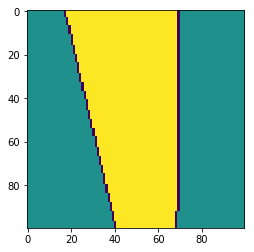

In [24]:
ibound = np.ones(dis.botm.shape, dtype=np.int)
init_head = np.zeros(dis.botm.shape, dtype=np.float)

ibound[5:, east_l2] = 0
ibound[5:, west_l2] = 0
for r,c in enumerate(idx_east_l2):
    ibound[5:, r, c] = -1
    init_head[5:, r, c] = -0.25
for r,c in enumerate(idx_west_l2):
    ibound[5:, r, c] = -1
    init_head[5:, r, c] = 0
# ibound[5:, :, idx_east_l2] = -1
# ibound[5:, :, idx_west_l2] = -1
# init_head[5:, :, idx_west_l2] = 0

# constant_heads = (ibound & ~si.binary_erosion(ibound, structure=np.ones((1, 1, 3))))
# ibound[constant_heads==1] = -1
# np.sum(ibound, axis=1)
# constant_heads
plt.imshow(ibound[5])

In [9]:
bas = flopy.modflow.ModflowBas(
    model=mf,
    ibound=ibound,
    strt=init_head
)
# ibound[0]

In [10]:
seed = gstools.random.MasterRNG(20190517)
# horizontal_conductivity = np.array([1, 1, 1, 1, 1, 5, 5, 5, 5, 5])

model_layer_1 = gstools.Gaussian(dim=3, var=1, len_scale=[50, 50, 5])
model_layer_2 = gstools.Gaussian(dim=3, var=2, len_scale=[40, 40, 3])

srf_layer_1 = gstools.SRF(model=model_layer_1, mean=25, upscaling='coarse_graining')
srf_layer_2 = gstools.SRF(model=model_layer_1, mean=35, upscaling='coarse_graining')

field_layer_1 = srf_layer_1(pos=(node_x[:5].flatten(), node_y[:5].flatten(), node_z[:5].flatten()), seed=seed(), point_volumes=node_vol[:5].flatten())
field_layer_1 = np.reshape(field_layer_1, node_x[:5].shape)
field_layer_2 = srf_layer_2(pos=(node_x[5:].flatten(), node_y[5:].flatten(), node_z[5:].flatten()), seed=seed(), point_volumes=node_vol[5:].flatten())
field_layer_2 = np.reshape(field_layer_1, node_x[5:].shape)
horizontal_conductivity = np.zeros(node_x.shape)
horizontal_conductivity[:5] = field_layer_1
horizontal_conductivity[5:] = field_layer_2
vertical_conductivity = horizontal_conductivity/10

lpf = flopy.modflow.ModflowLpf(
    model=mf,
    hk=horizontal_conductivity,
    vka=vertical_conductivity
)

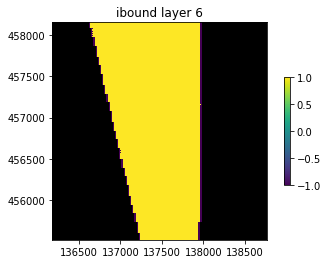

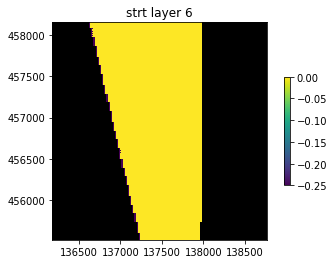

In [26]:
bas.plot(mflay=5)

In [11]:
ll = dis.get_rc_from_node_coordinates(137128-model_extent['X'][0], 456890-model_extent['Y'][0])
ur = dis.get_rc_from_node_coordinates(137206-model_extent['X'][0], 457041-model_extent['Y'][0])

recharge = np.ones(dis.botm.shape[1:], dtype=np.float)*0.200/365
recharge[(ur[0]):(ll[0]+1), (ll[1]):(ur[1]+1)] = 0
rch = flopy.modflow.ModflowRch(
    model=mf,
    rech=-recharge
)

In [12]:
oc_spd = {(p,s): ['SAVE HEAD', 'SAVE BUDGET'] for p, sp in enumerate(stress_periods) for s in range(sp['n_steps'])}
oc = flopy.modflow.ModflowOc(
    model=mf,
    stress_period_data=oc_spd
)

In [13]:
solver = flopy.modflow.ModflowPcg(
    model=mf
)

In [14]:
mf.write_input()
mf.run_model()

FloPy is using the following  executable to run the model: /home/hugo/modflow/bin/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: Griftpark.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2019/05/20 14:09:13

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2019/05/20 14:09:14
 Elapsed run time:  0.480 Seconds

  Normal termination of simulation


(True, [])

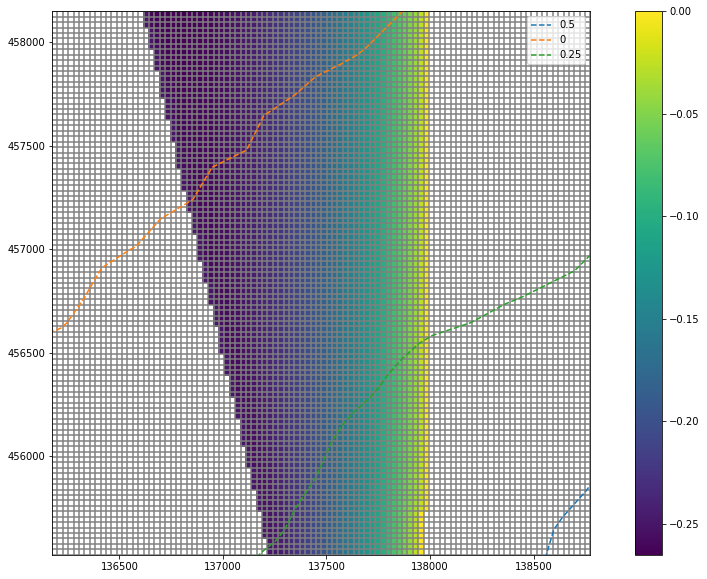

In [30]:
hds_file = flopy.utils.HeadFile(model_workspace / f'{modelname}.hds')
heads = hds_file.get_data()

fig, ax = plt.subplots(figsize=(16,10))
ax.set_aspect(1)
pmv = flopy.plot.PlotMapView(
    model=mf,
    ax=ax,
    layer=5,
)
pmv.plot_grid()
c = pmv.plot_array(heads, masked_values=[-999.99])
plt.colorbar(c)

model_min_x, model_min_y, model_max_x, model_max_y = model_bbox
fieldnames = [fn[0] for fn in contours_h1.fields[1:]]
level_index = fieldnames.index('M_NAP')
in_bbox = []
for shapeRec in contours_h1.iterShapeRecords():
    min_x, min_y, max_x, max_y = shapeRec.shape.bbox
    if min_x <= model_max_x and max_x >= model_min_x and min_y <= model_max_y and max_y >= model_min_y:
        points = np.array(shapeRec.shape.points)
        for point in points:
            x, y = point
            if x <= model_max_x and x >= model_min_x and y <= model_max_y and y >= model_min_y:
                in_bbox.append(shapeRec)
                ax.plot(points[:, 0], points[:, 1], '--', label=shapeRec.record[level_index])
                break
ax.legend()

# for contour in contours_h1.shapeRecords():
#     points = np.array(contour.shape.points)
# #     print(contour.shape.points)
#     ax.plot(points[:, 0], points[:, 1], '--', color='k')
# for contour in contours_h2.shapeRecords():
#     points = np.array(contour.shape.points)
# #     print(contour.shape.points)
#     ax.plot(points[:, 0], points[:, 1], '-.', color='k')
# #     break
# ax.plot(np.array([(136500, 456000), (138500, 457500)])[:, 0], np.array([(136500, 456000), (138500, 457500)])[:, 1], color='k')
# dir(ax)
# flopy.plot.plot_shapefile('data/h1.shp', cmap='viridis', ax=ax, linewidths=0.12)

In [31]:
in_bbox